<a href="https://colab.research.google.com/github/SaiArja/Trees_Near_Electric_wires/blob/main/Electrical_lines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Clasification of Trees which are near to the Electrical Lines***

***Intution***

Trees that grow too close to electric lines are a hazard. They can cause power outages or momentary power interruptions when branches touch overhead lines. Electrical arcing and sparking from a wire to a nearby branch can cause fires.When any part of a tree is electrified, the current passes through the tree’s tissues and into the ground. Similar to what happens with a lightning strike, the electricity superheats any moisture in the tree. Steam and boiling sap can erupt from the tree, taking bark, wood, and branches with it. Anything that’s touching the tree and the ground (like a person) will also act as a conductor. Energy will flow through the object or person, with similar outcomes as the tree.

Data Description

We have the colour images of the trees touching electric lines and trees not touching the electric lines and labels given in the csv file with image paths

**Plan Of Action**

The plan is to build a deep learning model that can clasify the trees touching the electrical lines. 

We will be using Transfer learning for creating the required model

**Importing the Required Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.applications.xception import Xception #Xception architecture
from tensorflow.keras.preprocessing import image
from keras.layers import Dense, GlobalAveragePooling2D, Input, Flatten, Dropout, BatchNormalization
from keras.models import Model, Sequential
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
# from keras.optimizers import adam
from tensorflow.keras.optimizers import Adam # - Works
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

Reading the Labels file as a Data Frame

In [2]:
#read the csv file as DataFrame
data_label = pd.read_csv('/content/drive/MyDrive/DataSets/DeepLearning/detect_trees_near_electric_wires/train.csv')

Seeing the First 5 rows of the dataFrame

In [3]:
#head() to see first 5 rows of the data
data_label.head()

,file_name,Intersection
0,Image_1.jpg,0
1,Image_2.jpg,1
2,Image_3.jpg,1
3,Image_4.jpg,1
4,Image_5.jpg,1


***Observation:- ***

the Data Frame has two columns 

1.**file_name** which has file name

2.**Intersection** which is a binary value which tells any contact between the electric wire and the tree(1 - contact; 0 - No Contact)

In [4]:
#checking the class count. 
data_label['Intersection'].value_counts()

1    826
0    616
Name: Intersection, dtype: int64

In the Whole data we have around 826 images which are showing the trees contacting the power lines and 618 images which show that power line are not contacting the trees

The data is kind of balanced now. we will see once again after splitting as train, validation, test

In [5]:
#Checking the number of images we have
data_label.shape

(1442, 2)

In [6]:
#changing the lables of the target variable from 1 and 0 to Yes and No
data_label.Intersection = pd.Series(np.where(data_label.Intersection.values == 1, 'yes', 'no'),
          data_label.index)

In [7]:
#Splitting the data in to train, test, validation sets
from sklearn.model_selection import train_test_split

def split_stratified_into_train_val_test(df_input, stratify_colname='Intersection',
                                         frac_train=0.7, frac_val=0.15, frac_test=0.15,
                                         random_state=32):
    '''
    Splits a Pandas dataframe into three subsets (train, val, and test)
    following fractional ratios provided by the user, where each subset is
    stratified by the values in a specific column (that is, each subset has
    the same relative frequency of the values in the column). It performs this
    splitting by running train_test_split() twice.

    Parameters
    ----------
    df_input : Pandas dataframe
        Input dataframe to be split.
    stratify_colname : str
        The name of the column that will be used for stratification. Usually
        this column would be for the label.
    frac_train : float
    frac_val   : float
    frac_test  : float
        The ratios with which the dataframe will be split into train, val, and
        test data. The values should be expressed as float fractions and should
        sum to 1.0.
    random_state : int, None, or RandomStateInstance
        Value to be passed to train_test_split().

    Returns
    -------
    df_train, df_val, df_test :
        Dataframes containing the three splits.
    '''

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError('fractions %f, %f, %f do not add up to 1.0' % \
                         (frac_train, frac_val, frac_test))

    if stratify_colname not in df_input.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_colname))

    X = df_input # Contains all columns.
    y = df_input[[stratify_colname]] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(df_temp,
                                                      y_temp,
                                                      stratify=y_temp,
                                                      test_size=relative_frac_test,
                                                      random_state=random_state)

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test

In [8]:
df_train, df_val, df_test = split_stratified_into_train_val_test(data_label)

Now my Data is devided in to 3 parts. train, test, and validation

In [55]:
#seeing how my train is
df_train.head()

,file_name,Intersection
788,Image_789.jpg,no
1255,Image_1256.jpg,yes
697,Image_698.jpg,yes
685,Image_686.jpg,no
1065,Image_1066.jpg,yes


In [10]:
#Checking the value counts of the train images
df_train['Intersection'].value_counts()

yes    578
no     431
Name: Intersection, dtype: int64

we have 578 images of the trees touching electrical lines and 431 images of the trees nlot touching lines. it is kind of balanced 🥦

In [11]:
df_val['Intersection'].value_counts()

yes    124
no      92
Name: Intersection, dtype: int64

the validation set has 124 and 92 images in the each class

In [12]:
df_test['Intersection'].value_counts()

yes    124
no      93
Name: Intersection, dtype: int64

Test has around 124 and 93 in each class

In [13]:
train_folder = '/content/drive/MyDrive/DataSets/DeepLearning/detect_trees_near_electric_wires/train'

this is the folder where all my images are saved

***Data Augmentation***

Data augmentation is a strategy that enables practitioners to significantly increase the diversity of data available for training models, without actually collecting new data. Data augmentation techniques such as cropping, padding, and horizontal flipping are commonly used to train large neural networks

In [14]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define your data generator
train_gen = ImageDataGenerator(
rotation_range=45,
rescale=1./255,
horizontal_flip=True
)
val_gen = ImageDataGenerator(
rotation_range=45,
rescale=1./255,
horizontal_flip=True
)
test_gen = ImageDataGenerator(rescale = 1./255)

Creating my Train, Test and Vaidation Data

In [15]:
train_data = train_gen.flow_from_dataframe(dataframe = df_train, x_col='file_name',
                                          directory = train_folder,y_col = 'Intersection',class_mode="binary",
                                          batch_size = 32, shuffle = True, 
                                          target_size = (299, 299)) #here iam going to use the Xception Architecture and its input size is (299, 299)

val_data = train_gen.flow_from_dataframe(dataframe = df_val, 
                                          directory = train_folder, x_col = 'file_name', 
                                          y_col = 'Intersection',
                                          batch_size = 32, shuffle = True, 
                                          class_mode="binary",target_size = (299, 299))


test_data = test_gen.flow_from_dataframe(dataframe = df_test, 
                                        directory = train_folder, x_col = 'file_name', 
                                        y_col = 'Intersection',
                                        batch_size = 32, shuffle = False, 
                                        target_size = (299, 299))

Found 1009 validated image filenames belonging to 2 classes.
Found 216 validated image filenames belonging to 2 classes.
Found 217 validated image filenames belonging to 2 classes.


In [16]:
#Creating an instance of the Xception Architecture
Xception = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=2,
    classifier_activation="binary",
)

83697664/83683744 [==============================] - 2s 0us/step


In [ ]:
# create the base pre-trained model
base_model = Xception(weights='imagenet', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

#Dropout Layer
x = Dropout(0.2)(x) # Regularize with dropout

# and a logistic layer
predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)

As we are using the Transfer Learning Technique, we will not train the base model. we will make those layers Freze and train the top Dense layers

In [ ]:
# don't train existing weights
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
#Check the model summary and trainable parameters
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_3[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                           

We can see that only 2049 are trainable which are of dense layers

In [ ]:
base_learning_rate = 0.0001

#Compile model
model.compile(optimizer=Adam(lr= base_learning_rate), loss= "binary_crossentropy", metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#epochs
initial_epochs = 20

# Callbacks
#Save best model
ckpt_filename= "/content/drive/MyDrive/DataSets/DeepLearning/detect_trees_near_electric_wires/base_model_weights1.hdf5"
checkpoint = ModelCheckpoint(filepath=ckpt_filename, save_best_only=True, save_weights_only=True, verbose = 1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, mode='min', verbose = 1)

In [ ]:
# Fitting the model
history = model.fit(train_data,
                    epochs=initial_epochs,
                    validation_data=val_data,
                    callbacks=[checkpoint, early_stop, lr_reduce]
                    )

Epoch 1/20
32/32 [==============================] - ETA: 0s - loss: 0.6845 - accuracy: 0.5610
Epoch 1: val_loss improved from inf to 0.68604, saving model to /content/drive/MyDrive/DataSets/DeepLearning/detect_trees_near_electric_wires/base_model_weights1.hdf5
32/32 [==============================] - 36s 1s/step - loss: 0.6845 - accuracy: 0.5610 - val_loss: 0.6860 - val_accuracy: 0.5694 - lr: 1.0000e-04
Epoch 2/20
32/32 [==============================] - ETA: 0s - loss: 0.6821 - accuracy: 0.5669
Epoch 2: val_loss improved from 0.68604 to 0.67146, saving model to /content/drive/MyDrive/DataSets/DeepLearning/detect_trees_near_electric_wires/base_model_weights1.hdf5
32/32 [==============================] - 36s 1s/step - loss: 0.6821 - accuracy: 0.5669 - val_loss: 0.6715 - val_accuracy: 0.6157 - lr: 1.0000e-04
Epoch 3/20
32/32 [==============================] - ETA: 0s - loss: 0.6731 - accuracy: 0.5808
Epoch 3: val_loss did not improve from 0.67146
32/32 [==============================] - 

the Model is Early stopped at Validation Accuracy of 65.28% and Validation loss 0.6254

Plotting the Learning Curves

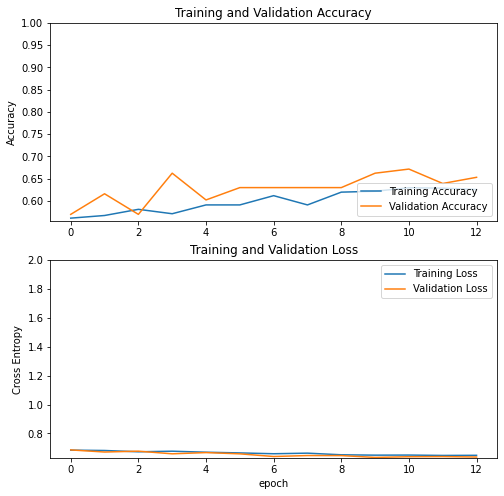

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Hyper Perameter Tuning**

In [ ]:
#Load the best model during initial training
model.load_weights(ckpt_filename)

In [ ]:
#unfreezing the layers of the base model
base_model.trainable = True

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_3[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                           

After Unfreezing you can see that training parameters are incresed to 20,809,001

In [ ]:
#compile model
model.compile(optimizer= Adam(lr=base_learning_rate/10), loss= "binary_crossentropy", metrics = ['accuracy'])

# Callbacks
final_ckpt_filename= "/content/drive/MyDrive/DataSets/DeepLearning/detect_trees_near_electric_wires/base_model_weight_best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=final_ckpt_filename, save_best_only=True, save_weights_only=True, verbose = 1)

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, mode='min', verbose = 1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
fine_tune_epochs = 20

# Fitting the model
history_unfreeze = model.fit(train_data,
                    epochs= fine_tune_epochs,
                    validation_data=val_data,
                    callbacks=[checkpoint, early_stop, lr_reduce],
                    )

Epoch 1/20
32/32 [==============================] - ETA: 0s - loss: 0.6985 - accuracy: 0.5134
Epoch 1: val_loss improved from inf to 0.64083, saving model to /content/drive/MyDrive/DataSets/DeepLearning/detect_trees_near_electric_wires/base_model_weight_best_model.hdf5
32/32 [==============================] - 56s 1s/step - loss: 0.6985 - accuracy: 0.5134 - val_loss: 0.6408 - val_accuracy: 0.6713 - lr: 1.0000e-05
Epoch 2/20
32/32 [==============================] - ETA: 0s - loss: 0.6746 - accuracy: 0.5847
Epoch 2: val_loss improved from 0.64083 to 0.62569, saving model to /content/drive/MyDrive/DataSets/DeepLearning/detect_trees_near_electric_wires/base_model_weight_best_model.hdf5
32/32 [==============================] - 49s 2s/step - loss: 0.6746 - accuracy: 0.5847 - val_loss: 0.6257 - val_accuracy: 0.6898 - lr: 1.0000e-05
Epoch 3/20
32/32 [==============================] - ETA: 0s - loss: 0.6548 - accuracy: 0.6244
Epoch 3: val_loss improved from 0.62569 to 0.61613, saving model to /c

After Hyper perameter tuning, the model Accuracy incresed to 75%

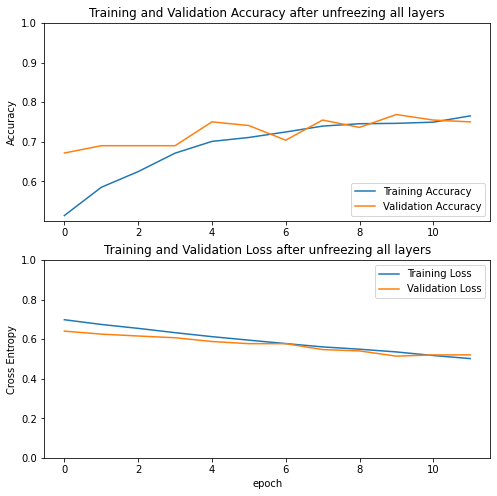

In [ ]:
acc = history_unfreeze.history['accuracy']
val_acc = history_unfreeze.history['val_accuracy']

loss = history_unfreeze.history['loss']
val_loss = history_unfreeze.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy after unfreezing all layers')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss after unfreezing all layers')
plt.xlabel('epoch')
plt.show()

In [ ]:
#Load the best model
model.load_weights(final_ckpt_filename)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_3[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                           

**Testing**

In [ ]:
#Evaluate on the test data
test_loss, test_score = model.evaluate(test_data)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

7/7 [==============================] - 3s 338ms/step - loss: 0.7865 - accuracy: 0.5000
Loss on test set:  0.7864599227905273
Accuracy on test set:  0.5


In [ ]:
preds = model.predict(test_data) # Predicting on test data

In [ ]:
test_data_labels = df_test.Intersection.map(dict(yes=1, no=0)) # Label encoding

In [ ]:
test_data_labels

291     1
1216    1
396     0
1198    0
856     1
       ..
22      1
1088    0
10      0
540     0
214     1
Name: Intersection, Length: 217, dtype: int64

In [ ]:
# Classification report 
from sklearn.metrics import accuracy_score,classification_report, roc_curve, confusion_matrix

acc = accuracy_score(test_data_labels, np.round(preds))*100
print("Test data accuracy : "+str(acc))
print("Classification report")
print(classification_report(test_data_labels ,np.round(preds)))

Test data accuracy : 71.42857142857143
Classification report
              precision    recall  f1-score   support

           0       0.72      0.54      0.62        93
           1       0.71      0.85      0.77       124

    accuracy                           0.71       217
   macro avg       0.72      0.69      0.69       217
weighted avg       0.72      0.71      0.71       217



We got the Test Accuracy of 71.42%

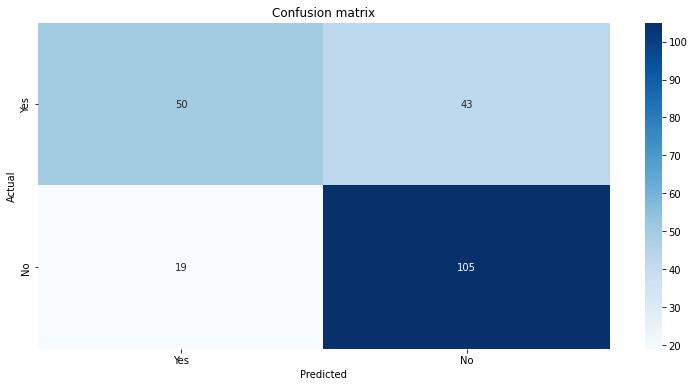

In [ ]:
#Plot the confusion matrix
import seaborn as sns
conf_matrix = confusion_matrix(test_data_labels, np.round(preds))
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=['Yes', 'No'], 
            yticklabels=['Yes', 'No'],
            cmap="Blues",
            fmt='g')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show()

After training our model, we got following

**Training Accuracy is 76%**

**Validation Accuracy is 75%**

**Test Accuracy is 71%**

Its a Good Score lets try on the other model also

**Implimenting VVG16**

Creating our data as per the VVG16 requirements

In [20]:
train_data = train_gen.flow_from_dataframe(dataframe = df_train, x_col='file_name',
                                          directory = train_folder,y_col = 'Intersection',class_mode="binary",
                                          batch_size = 32, shuffle = True, 
                                          target_size = (224, 224))

val_data = train_gen.flow_from_dataframe(dataframe = df_val, 
                                          directory = train_folder, x_col = 'file_name', 
                                          y_col = 'Intersection',
                                          batch_size = 32, shuffle = True, 
                                          class_mode="binary",target_size = (224, 224))


test_data = test_gen.flow_from_dataframe(dataframe = df_test, 
                                        directory = train_folder, x_col = 'file_name', 
                                        y_col = 'Intersection',
                                        batch_size = 32, shuffle = False, 
                                        target_size = (224, 2))

Found 1009 validated image filenames belonging to 2 classes.
Found 216 validated image filenames belonging to 2 classes.
Found 217 validated image filenames belonging to 2 classes.


In [18]:
from tensorflow.keras.applications.vgg16 import VGG16 #importing VVG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [26]:
base_model = VGG16(weights="imagenet", include_top=False) #downloading the model

58900480/58889256 [==============================] - 1s 0us/step


In [29]:
base_model.trainable = False ## Not trainable weights

In [30]:
base_model.summary() #seeing the summary

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [38]:
x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

#Dropout Layer
x = Dropout(0.2)(x) # Regularize with dropout

# and a logistic layer
predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [39]:
#Follow ChexNeXt Paper
base_learning_rate = 0.0001

#Compile model
model.compile(optimizer=Adam(lr= base_learning_rate), loss= "binary_crossentropy", metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [40]:
#epochs
initial_epochs = 20

# Callbacks
#Save best model
ckpt_filename= "/content/drive/MyDrive/DataSets/DeepLearning/detect_trees_near_electric_wires/VVG16_base_model_weights1.hdf5"
checkpoint = ModelCheckpoint(filepath=ckpt_filename, save_best_only=True, save_weights_only=True, verbose = 1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, mode='min', verbose = 1)

In [41]:
# Fitting the model
history = model.fit(train_data,
                    epochs=initial_epochs,
                    validation_data=val_data,
                    callbacks=[checkpoint, early_stop, lr_reduce]
                    )

Epoch 1/20
32/32 [==============================] - ETA: 0s - loss: 0.6948 - accuracy: 0.5273 
Epoch 1: val_loss improved from inf to 0.68579, saving model to /content/drive/MyDrive/DataSets/DeepLearning/detect_trees_near_electric_wires/VVG16_base_model_weights1.hdf5
32/32 [==============================] - 665s 20s/step - loss: 0.6948 - accuracy: 0.5273 - val_loss: 0.6858 - val_accuracy: 0.5602 - lr: 1.0000e-04
Epoch 2/20
32/32 [==============================] - ETA: 0s - loss: 0.7029 - accuracy: 0.5213
Epoch 2: val_loss improved from 0.68579 to 0.68121, saving model to /content/drive/MyDrive/DataSets/DeepLearning/detect_trees_near_electric_wires/VVG16_base_model_weights1.hdf5
32/32 [==============================] - 32s 996ms/step - loss: 0.7029 - accuracy: 0.5213 - val_loss: 0.6812 - val_accuracy: 0.5880 - lr: 1.0000e-04
Epoch 3/20
32/32 [==============================] - ETA: 0s - loss: 0.6945 - accuracy: 0.5471
Epoch 3: val_loss did not improve from 0.68121
32/32 [================

This model performed very poor. this may be due to the fact that this model only 16 Conv layers. 

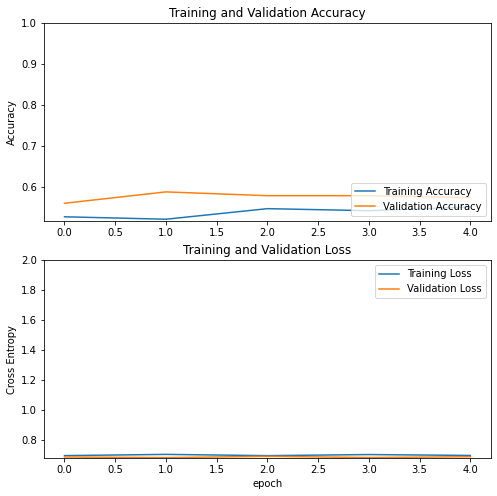

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [43]:
#Load the best model during initial training
model.load_weights(ckpt_filename)

In [44]:
base_model.trainable = True

In [45]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [46]:
#compile model
model.compile(optimizer= Adam(lr=base_learning_rate/10), loss= "binary_crossentropy", metrics = ['accuracy'])

# Callbacks
final_ckpt_filename= "/content/drive/MyDrive/DataSets/DeepLearning/detect_trees_near_electric_wires/VGG16_base_model_weight_best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=final_ckpt_filename, save_best_only=True, save_weights_only=True, verbose = 1)

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=6, mode='min', verbose = 1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [47]:
# Fitting the model
history = model.fit(train_data,
                    epochs=initial_epochs,
                    validation_data=val_data,
                    callbacks=[checkpoint, early_stop, lr_reduce]
                    )

Epoch 1/20
32/32 [==============================] - ETA: 0s - loss: 0.6867 - accuracy: 0.5580
Epoch 1: val_loss improved from inf to 0.65596, saving model to /content/drive/MyDrive/DataSets/DeepLearning/detect_trees_near_electric_wires/VGG16_base_model_weight_best_model.hdf5
32/32 [==============================] - 48s 1s/step - loss: 0.6867 - accuracy: 0.5580 - val_loss: 0.6560 - val_accuracy: 0.5926 - lr: 1.0000e-05
Epoch 2/20
32/32 [==============================] - ETA: 0s - loss: 0.6705 - accuracy: 0.5917
Epoch 2: val_loss improved from 0.65596 to 0.64420, saving model to /content/drive/MyDrive/DataSets/DeepLearning/detect_trees_near_electric_wires/VGG16_base_model_weight_best_model.hdf5
32/32 [==============================] - 39s 1s/step - loss: 0.6705 - accuracy: 0.5917 - val_loss: 0.6442 - val_accuracy: 0.6574 - lr: 1.0000e-05
Epoch 3/20
32/32 [==============================] - ETA: 0s - loss: 0.6447 - accuracy: 0.6482
Epoch 3: val_loss improved from 0.64420 to 0.60604, saving

After Hyper perameter Tuning, our model is able to give 76% accuracy

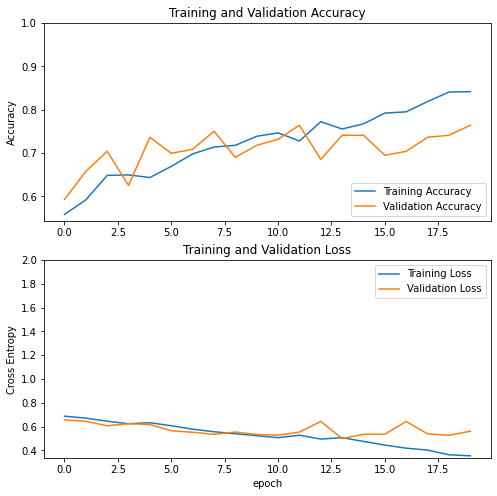

In [48]:
 acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [49]:
#Load the best model
model.load_weights(final_ckpt_filename)

In [50]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [51]:
#Evaluate on the test data
test_loss, test_score = model.evaluate(test_data)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

7/7 [==============================] - 104s 17s/step - loss: 0.9194 - accuracy: 0.5000
Loss on test set:  0.9193534851074219
Accuracy on test set:  0.5


In [52]:
preds = model.predict(test_data)
test_data_labels = df_test.Intersection.map(dict(yes=1, no=0))

In [53]:
# Classification report 
from sklearn.metrics import accuracy_score,classification_report, roc_curve, confusion_matrix

acc = accuracy_score(test_data_labels, np.round(preds))*100
print("Test data accuracy : "+str(acc))
print("Classification report")
print(classification_report(test_data_labels ,np.round(preds)))

Test data accuracy : 70.96774193548387
Classification report
              precision    recall  f1-score   support

           0       0.70      0.56      0.62        93
           1       0.71      0.82      0.76       124

    accuracy                           0.71       217
   macro avg       0.71      0.69      0.69       217
weighted avg       0.71      0.71      0.70       217



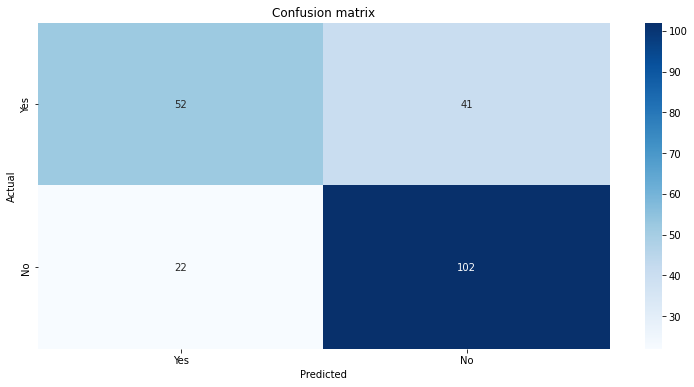

In [54]:
#Plot the confusion matrix
import seaborn as sns
conf_matrix = confusion_matrix(test_data_labels, np.round(preds))
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=['Yes', 'No'], 
            yticklabels=['Yes', 'No'],
            cmap="Blues",
            fmt='g')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show()

Our VGG16 model is able to give the Test accuracy 70.96, Validation Accuracy as 76% and training accyuracy as 84.1%

The model seems to be over fitting. lets try another model